# Preamble

## Imports

In [1]:
##ALL OF THE IMPORTS AND SUCH

import os
from concurrent.futures import ProcessPoolExecutor, as_completed


from LightPipes import *
from LightPipes import Field

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import math
import cmath
from numpy import genfromtxt
import colorcet as cc
import random
import aotools
import itertools
from tqdm import tqdm as progress
import random

import numpy as np
from numpy.linalg import eig,eigh
import scipy as sp

import pylab as pl

#plt.style.use('dark_background')
plt.close('all')

## Crap for making videos - NOT IMPORTANT KEEP COMMENTED OUT but maybe we can put it in the functions

In [2]:
# plt.show(plotBeamTransparent(Fqubit(F,w,4,0,2,0)))

In [3]:
# N=128
# w=8.1*cm

# F=Begin(size=40*cm,labda=633*nm,N=N)
# #beamlist=[OAM(F,w,j) for j in ell(8)] + [ANG(F,w,8,j) for j in range(8)]
# d=4
# k,m=3,0

# beamlist=[Fqubit(F,w,d,j,k,m) for j in [0,1,2] for k in range(j+1,d) for m in range(d)]

# for i,phase in enumerate(np.arange(0,2*np.pi,np.pi/120)):
#     fig=plotBeamTransparent([SubPhase(beam,Phase(beam)+phase) for beam in beamlist],dpi=N,rows=2)
#     plt.savefig(f"figs/fqb/output{i:03d}.png",pad_inches=0,dpi=N)
#     plt.close(fig)


In [4]:
# import subprocess
# import os

# def create_transparent_webm(image_folder, output_name="beam_movie.webm", fps=120):
#     # Ensure filenames are sorted (e.g., output0.png, output1.png...)
#     # We use a text file list for FFmpeg to handle non-sequential naming
#     input_list = "images.txt"
#     filenames = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
    
#     with open(input_list, "w") as f:
#         for fname in filenames:
#             f.write(f"file '{os.path.join(image_folder, fname)}'\n")

#     # FFmpeg command for VP9 WebM with Alpha:
#     # -f concat: use the text file list
#     # -pix_fmt yuva420p: The 'a' stands for Alpha (transparency support)
#     # -auto-alt-ref 0: Required for transparency in some VP9 versions
#     cmd = [
#         'ffmpeg', '-y', 
#         '-r', str(fps), 
#         '-f', 'concat', '-safe', '0', '-i', input_list,
#         '-c:v', 'libvpx-vp9', 
#         '-pix_fmt', 'yuva420p', 
#         '-auto-alt-ref', '0', 
#         output_name
#     ]

#     try:
#         subprocess.run(cmd, check=True)
#         print(f"Successfully saved transparent video: {output_name}")
#     except subprocess.CalledProcessError as e:
#         print(f"Error running FFmpeg: {e}")
#     finally:
#         if os.path.exists(input_list):
#             os.remove(input_list)


In [5]:
# create_transparent_webm('figs/fqb', 'vids/fqb_02s.webm', fps=120)

## Colours

In [6]:
#Generate Colormap Intensity
cmap = np.zeros([256, 4])
cmap[:, 3] = np.linspace(0, 1, 256)
cmap[:, 0]= np.linspace(0, 0, 256)
cmap[:, 1]= np.linspace(0, 0, 256)
cmap[:, 2]= np.linspace(0, 0, 256)
#Intensity colours
imap = matplotlib.colors.ListedColormap(cmap)
#Phase colours
pmap= cc.m_CET_C6

### Saving Colourbars

In [7]:
cmap = pmap
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig = pl.figure(figsize=(6, 1), dpi=300) 
ax = fig.add_axes([0, 0, 1, 1]) 
cb = pl.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                 cax=ax, 
                 orientation="horizontal", 
                 ticks=[])
ax.set_axis_off() 
os.makedirs("images", exist_ok=True)
pl.savefig("images/phaseColorbar.png", 
           bbox_inches='tight', 
           pad_inches=0)
pl.close(fig) 

cmap = 'viridis'
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig = pl.figure(figsize=(6, 1), dpi=300) 
ax = fig.add_axes([0, 0, 1, 1]) 
cb = pl.colorbar(pl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                 cax=ax, 
                 orientation="horizontal", 
                 ticks=[])
ax.set_axis_off() 
pl.savefig("images/uniform0-1Colorbar.png", 
           bbox_inches='tight', 
           pad_inches=0)
pl.close(fig) 

In [8]:
customColoursBGY = [
    (0.,0.047803,0.4883,1.),
    (0.,0.27531,0.72221,1),
    (0.10786,0.56059,0.38276,1.),
    (0.21196,0.82159,0.099996,1.),
    (1.,0.94606,0.13735,1.)
    ]

customColoursViridis = [
    (0.267004, 0.004874, 0.329415, 1.      ),
    (0.229739, 0.322361, 0.545706, 1.      ),
    (0.127568, 0.566949, 0.550556, 1.      ),
    (0.369214, 0.788888, 0.382914, 1.      ),
    (0.993248, 0.906157, 0.143936, 1.      )
]

## Functions

In [9]:
# Defines mode indices even about 0 for d dimensions
def ell(d):
    if d%2 == 0:
        l=np.linspace(-np.floor(d/2),np.floor(d/2),d+1,dtype=int)
        l=l[l != 0]
    else:
        l=np.linspace(-np.floor(d/2),np.floor(d/2),d,dtype=int)
    return l

#Phases for arbitrary MUBs in prime dimensions
def MUBphases(d,MUB):
    phi,p=[],[]
    for state in range(d):
        for j in range(d):
            p.append(((2*np.pi/d)*(MUB*(j**2)+state*j)))
        phi.append(p)
        p=[]
    return phi

#Mixing large amount of beams in a loop
def MixManyBeams(beams):
    if len(beams) > 1:
        beams[1]=BeamMix(beams[0],beams[1])
        beams.pop(0)
        MixManyBeams(beams)
    return beams[0]

#OAM beams 
def OAM(F, w0, state: int=0 ,phase=0,amp: float=1.0):
    F=GaussLaguerre(F, w0, p=0, l=state, A=amp*(1/w0)*np.sqrt(2/(np.pi*(math.factorial(abs(state))))), ecs=0)
    F=SubPhase(F,Phase(F)+phase)
    return F

#Arbitrary ANG mode in dimension d
def ANG(F,w0,d,state,norm=0):
    intensityNorm=[1,1,187.3568368182197,302.7415771427128,281.4774347094998,342.95046333063704,1,330.2491174614896,276.25225696328897,1,1,1,1,1,1,1,1,1,1,1,1,1]
    Q,p=[],[]
    l=ell(d)
    
    for i in range(d):
        p.append((2*np.pi/d)*i*state)

    for i in range(d):
        Q.append(OAM(F,w0,l[i],p[i]))

    F=MixManyBeams(Q)

    if norm==1:
        return [F,intensityNorm[d]]
    else:
        return F

#Arbitrary MUB in d dimensions {2,3,4,5,7,8}
def ArbMUB(F,w0,d,MUB,state,norm=0):
    intensityNorm=[1,1,187.3568368182197,302.7415771427128,281.4774347094998,342.95046333063704,1,330.2491174614896,276.25225696328897,1,1,1,1,1,1,1,1,1,1,1,1,1]
    Q,p=[],[]
    l=ell(d)
    if d==2:
        p=[[[0,0],[0,np.pi]],[[0,np.pi/2],[0,3*np.pi/2]]][MUB][state]
    elif d==4:
        p=[[[0,0,0,0],[0,np.pi,np.pi,0],[0,0,np.pi,np.pi],[0,np.pi,0,np.pi]],[[0,np.pi/2,np.pi/2,np.pi],[0,3*np.pi/2,3*np.pi/2,np.pi],[0,np.pi/2,3*np.pi/2,0],[0,3*np.pi/2,np.pi/2,0]],[[0,0,3*np.pi/2,np.pi/2],[0,np.pi,np.pi/2,np.pi/2],[0,0,np.pi/2,3*np.pi/2],[0,np.pi,3*np.pi/2,3*np.pi/2]],[[0,3*np.pi/2,0,np.pi/2],[0,np.pi/2,np.pi,np.pi/2],[0,np.pi/2,0,3*np.pi/2],[0,3*np.pi/2,np.pi,3*np.pi/2]]][MUB][state]
    elif d==8:
        p=[[[0,0,0,0,0,0,0,0],[0,np.pi/2,np.pi/2,np.pi,np.pi/2,np.pi,np.pi,3*np.pi/2],[0,np.pi/2,0,np.pi/2,0,3*np.pi/2,np.pi,np.pi/2],[0,0,np.pi/2,np.pi/2,np.pi/2,3*np.pi/2,0,np.pi],[0,0,np.pi/2,3*np.pi/2,0,np.pi,np.pi/2,np.pi/2],[0,np.pi/2,0,3*np.pi/2,np.pi/2,0,np.pi/2,np.pi],[0,np.pi/2,np.pi/2,0,0,np.pi/2,3*np.pi/2,np.pi],[0,0,0,np.pi,np.pi/2,np.pi/2,3*np.pi/2,np.pi/2]],[[0,np.pi,0,np.pi,0,np.pi,0,np.pi],[0,3*np.pi/2,np.pi/2,0,np.pi/2,0,np.pi,np.pi/2],[0,3*np.pi/2,0,3*np.pi/2,0,np.pi/2,np.pi,3*np.pi/2],[0,np.pi,np.pi/2,3*np.pi/2,np.pi/2,np.pi/2,0,0],[0,np.pi,np.pi/2,np.pi/2,0,0,np.pi/2,3*np.pi/2],[0,3*np.pi/2,0,np.pi/2,np.pi/2,np.pi,np.pi/2,0],[0,3*np.pi/2,np.pi/2,np.pi,0,3*np.pi/2,3*np.pi/2,0],[0,np.pi,0,0,np.pi/2,3*np.pi/2,3*np.pi/2,3*np.pi/2]],[[0,0,np.pi,np.pi,0,0,np.pi,np.pi],[0,np.pi/2,3*np.pi/2,0,np.pi/2,np.pi,0,np.pi/2],[0,np.pi/2,np.pi,3*np.pi/2,0,3*np.pi/2,0,3*np.pi/2],[0,0,3*np.pi/2,3*np.pi/2,np.pi/2,3*np.pi/2,np.pi,0],[0,0,3*np.pi/2,np.pi/2,0,np.pi,3*np.pi/2,3*np.pi/2],[0,np.pi/2,np.pi,np.pi/2,np.pi/2,0,3*np.pi/2,0],[0,np.pi/2,3*np.pi/2,np.pi,0,np.pi/2,np.pi/2,0],[0,0,np.pi,0,np.pi/2,np.pi/2,np.pi/2,3*np.pi/2]],[[0,np.pi,np.pi,0,0,np.pi,np.pi,0],[0,3*np.pi/2,3*np.pi/2,np.pi,np.pi/2,0,0,3*np.pi/2],[0,3*np.pi/2,np.pi,np.pi/2,0,np.pi/2,0,np.pi/2],[0,np.pi,3*np.pi/2,np.pi/2,np.pi/2,np.pi/2,np.pi,np.pi],[0,np.pi,3*np.pi/2,3*np.pi/2,0,0,3*np.pi/2,np.pi/2],[0,3*np.pi/2,np.pi,3*np.pi/2,np.pi/2,np.pi,3*np.pi/2,np.pi],[0,3*np.pi/2,3*np.pi/2,0,0,3*np.pi/2,np.pi/2,np.pi],[0,np.pi,np.pi,np.pi,np.pi/2,3*np.pi/2,np.pi/2,np.pi/2]],[[0,0,0,0,np.pi,np.pi,np.pi,np.pi],[0,np.pi/2,np.pi/2,np.pi,3*np.pi/2,0,0,np.pi/2],[0,np.pi/2,0,np.pi/2,np.pi,np.pi/2,0,3*np.pi/2],[0,0,np.pi/2,np.pi/2,3*np.pi/2,np.pi/2,np.pi,0],[0,0,np.pi/2,3*np.pi/2,np.pi,0,3*np.pi/2,3*np.pi/2],[0,np.pi/2,0,3*np.pi/2,3*np.pi/2,np.pi,3*np.pi/2,0],[0,np.pi/2,np.pi/2,0,np.pi,3*np.pi/2,np.pi/2,0],[0,0,0,np.pi,3*np.pi/2,3*np.pi/2,np.pi/2,3*np.pi/2]],[[0,np.pi,0,np.pi,np.pi,0,np.pi,0],[0,3*np.pi/2,np.pi/2,0,3*np.pi/2,np.pi,0,3*np.pi/2],[0,3*np.pi/2,0,3*np.pi/2,np.pi,3*np.pi/2,0,np.pi/2],[0,np.pi,np.pi/2,3*np.pi/2,3*np.pi/2,3*np.pi/2,np.pi,np.pi],[0,np.pi,np.pi/2,np.pi/2,np.pi,np.pi,3*np.pi/2,np.pi/2],[0,3*np.pi/2,0,np.pi/2,3*np.pi/2,0,3*np.pi/2,np.pi],[0,3*np.pi/2,np.pi/2,np.pi,np.pi,np.pi/2,np.pi/2,np.pi],[0,np.pi,0,0,3*np.pi/2,np.pi/2,np.pi/2,np.pi/2]],[[0,0,np.pi,np.pi,np.pi,np.pi,0,0],[0,np.pi/2,3*np.pi/2,0,3*np.pi/2,0,np.pi,3*np.pi/2],[0,np.pi/2,np.pi,3*np.pi/2,np.pi,np.pi/2,np.pi,np.pi/2],[0,0,3*np.pi/2,3*np.pi/2,3*np.pi/2,np.pi/2,0,np.pi],[0,0,3*np.pi/2,np.pi/2,np.pi,0,np.pi/2,np.pi/2],[0,np.pi/2,np.pi,np.pi/2,3*np.pi/2,np.pi,np.pi/2,np.pi],[0,np.pi/2,3*np.pi/2,np.pi,np.pi,3*np.pi/2,3*np.pi/2,np.pi],[0,0,np.pi,0,3*np.pi/2,3*np.pi/2,3*np.pi/2,np.pi/2]],[[0,np.pi,np.pi,0,np.pi,0,0,np.pi],[0,3*np.pi/2,3*np.pi/2,np.pi,3*np.pi/2,np.pi,np.pi,np.pi/2],[0,3*np.pi/2,np.pi,np.pi/2,np.pi,3*np.pi/2,np.pi,3*np.pi/2],[0,np.pi,3*np.pi/2,np.pi/2,3*np.pi/2,3*np.pi/2,0,0],[0,np.pi,3*np.pi/2,3*np.pi/2,np.pi,np.pi,np.pi/2,3*np.pi/2],[0,3*np.pi/2,np.pi,3*np.pi/2,3*np.pi/2,0,np.pi/2,0],[0,3*np.pi/2,3*np.pi/2,0,np.pi,np.pi/2,3*np.pi/2,0],[0,np.pi,np.pi,np.pi,3*np.pi/2,np.pi/2,3*np.pi/2,3*np.pi/2]]][state][MUB]
    else:
        for j in range(d):
            p.append(((2*np.pi/d)*(MUB*(j**2)+state*j)))
            
    for i in range(d):
        Q.append(OAM(F,w0,l[i],p[i]))
    F=MixManyBeams(Q)

    if norm==1:
        return [F,intensityNorm[d]]
    else:
        return F
    

#Arbitrary FQubit mode in dimension d
def Fqubit(F,w0,d=3,j=0,k=1,m=0):
    l=ell(d)
    p=(2*np.pi/d)*m
    
    Q=BeamMix(OAM(F,w0,l[j],0),OAM(F,w0,l[k],p))
    return Q

### Generating Beam Plots

In [10]:
#Show a plot of a single beam, or an array of beams with phase and intensity
def plotBeam(Fs: list[Field],rows: int=1,aperature: float=0,intensity: bool=True,phase: bool=True,dpi: int=300) -> plt.Figure:
    
    """
    Show a plot of a single beam, or an array of beams with phase and intensity. This plot can be saved as an image. using the filename argument.

    Args:
        Fs: Field from LightPipes or list of Fields.
        rows: Number of rows in the plot grid.
        aperature: Size of aperature to draw around each beam (in metres).
        intensity: Whether to show intensity plot.
        phase: Whether to show phase plot.
        dpi: Dots per inch for the output image.
    """

    if not hasattr(Fs, "__len__"):
        Fs=[Fs]

    totalModes = len(Fs)
    if rows>=totalModes:
        columns=1
        rows=totalModes
    else:
        columns = totalModes//rows + (1 if totalModes%rows else 0)
    Position = range(1,totalModes + 1)

    fig_width = columns
    fig_height = rows

    fig = plt.figure(1,figsize=(fig_width, fig_height),dpi=dpi)

    pixels,size=Fs[0].N,Fs[0].siz

    for index,F in enumerate(Fs):
        I=1-Intensity(1,F)
        Phi=np.mod(Phase(F),2*np.pi)

        ax = fig.add_subplot(rows,columns,Position[index])
        ax.set_facecolor('black')
        ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.margins(0)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        ax.imshow(Phi,cmap=pmap,vmin=0,vmax=2*np.pi,interpolation='None') if phase==True else None
        ax.imshow(I,cmap=imap if phase==True else plt.colormaps['gray_r'] ,vmin=np.min(I),vmax=np.max(I),interpolation='None') if intensity ==True else None

        if aperature:
            centre=(pixels/2-0.5,pixels/2-0.5) if pixels%2 == 1 else (pixels/2,pixels/2)
            circle = plt.Circle(centre,aperature*pixels/size, color='w', fill=False,linewidth=0.5)
            ax.add_patch(circle)

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    fig.tight_layout(pad=0, w_pad=0, h_pad=0)

    return fig


In [11]:
def plotBeamTransparent(Fs, rows=1, intensity=True, phase=True, dpi=300):
    Fs = Fs if isinstance(Fs, list) else [Fs]
    num_beams = len(Fs)
    cols = (num_beams + rows - 1) // rows
    
    # Use the grid size of the field (e.g., 512)
    N = Fs[0].N 
    
    # Calculate figure size in inches to hit exact pixel targets
    fig_w = (cols * N) / dpi
    fig_h = (rows * N) / dpi
    
    # Create figure with NO frame or padding
    fig = plt.figure(figsize=(fig_w, fig_h), dpi=dpi, facecolor='none')
    
    for i in range(num_beams):
        # Calculate position for each subplot manually to ensure 0 padding
        # [left, bottom, width, height] in normalized coordinates (0 to 1)
        col_idx = i % cols
        row_idx = rows - 1 - (i // cols) # Start from top
        
        ax_pos = [col_idx/cols, row_idx/rows, 1/cols, 1/rows]
        ax = fig.add_axes(ax_pos)
        ax.set_axis_off()
        
        F = Fs[i]
        I = Intensity(F)
        P = np.mod(Phase(F), 2 * np.pi)
        
        
        norm_I = (I - I.min()) / (I.max() - I.min()) if I.max() > I.min() else I
        rgba = pmap(P / (2 * np.pi))
        rgba[..., 3] = norm_I if intensity else 1.0
        
        if not phase: 
            rgba[..., :3] = 0.5
            
        ax.imshow(rgba, interpolation='nearest', aspect='auto')

    return fig

### Overlap integrals and crosstalk

In [12]:
#These are custom functions to calculate the overlap integral between two modes

# This is the overlap integral to check the fidelity between two modes
def overlapInt(F,G):
    F,G=Normal(F),Normal(G)
    Ffield,Gfield=np.conjugate(F.field),G.field
    fieldArr=np.multiply(Ffield,Gfield)
    summed=abs(np.sum(fieldArr))**2
    return summed

#Normalizes the overlap integrals for a tomographic measurement in dimension d. 
def normTomography(ints, d):
    return np.concatenate([
        chunk / chunk.sum() if chunk.sum() != 0 else chunk
        for chunk in np.split(ints, range(d, len(ints), d))
    ])

#Crosstalk of two vectors
def crosstalkVecs(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(abs(np.dot(np.conjugate(F),G))**2)
        C.append(c/sum(c))
    return C

#Calculate full crosstalk of two beam lists
def crosstalk(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(overlapInt(F,G))
        C.append(c/sum(c))
    return C

def tomography(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(overlapInt(F,G))
        C.append(normTomography(c,math.isqrt(len(Fs))))
    return C

def plotCrosstalk(cross):
    fig = plt.figure(1)
    plt.axis('off')
    plt.imshow(cross, interpolation='none', cmap='viridis', vmin=0,vmax=1)
    return fig

def beamsError(Fs,Gs):
    array=crosstalk(Fs,Gs)
    error=1-np.mean([diag[i] for i,diag in enumerate(array)])
    return error

### Propagation

In [13]:
#Propagates one beam through the channel defined by the distance and the list of abberations that is input (abbs)
#If there are abberations, distance is the distance per abberation
def propChannel(F,distance,abbs=1,mode=0):
    if not hasattr(abbs, "__len__"):
        for i in range(abbs):
            if mode==1:
                F=Forvard(F,distance/abbs)
            elif mode == 2:
                F=Forward(F,distance/abbs,F.siz,F.N)
            else:
                F=Fresnel(F,distance/abbs)

    else:
        F=Fresnel(F,distance/(len(abbs)+1))
        for screen in abbs:
            F=SubPhase(F,Phase(F)+screen)
            if mode==1:
                F=Forvard(F,distance/(len(abbs)+1))
            elif mode == 2:
                F=Forward(F,distance/(len(abbs)+1),F.size,F.N)
            else:
                F=Fresnel(F,distance/(len(abbs)+1))
    return F

def propChannelSteps(F,distance,abbs=1):
    Fs=[]
    if not hasattr(abbs, "__len__"):
        for i in abbs:
            F=Forvard(F,int(distance/abbs))
            Fs.append(F)
            F=Forvard(F,distance)
    else:
        for screen in abbs:
            F=SubPhase(F,Phase(F)+screen)
            F=Forvard(F,int(distance/len(abbs)))
            Fs.append(F)
    return ([F,Fs])

### Parallelization of propagation of all pixels

In [14]:
def propagateSinglePixel(FieldIn: Field,j: int, i:int, N:int, z:float, lensSize:float, abbs) -> tuple:
    """
    Performs the calculation for a single (j, i) pair.

    Args:
        FieldIn: Initial field.
        j (int): Outer loop index.
        i (int): Inner loop index.
        N (int): Grid size.
        z (float): Propagation distance.
        abbs: List of numpy ndarray representing phase screens.

    Returns:
        tuple: (FieldOut, endField_data) for the specific (j, i)
    """

    print('Worker started')    
    
    # 1. Create the intensity matrix
    intens = np.zeros((N, N))
    intens[j][i] = 1

    fieldAtSender=CircAperture(SubPhase(SubIntensity(FieldIn, intens),np.zeros((N,N))),lensSize)

    
    #FieldOut = propChannel(SubIntensity(FieldIn, intens), z, abbs)
    #FieldOut = propChannel(CircAperture(SubIntensity(FieldIn, intens),lensSize), z, abbs)
    FieldOut = CircAperture(propChannel(fieldAtSender, z, abbs),lensSize)

    # 4. Extract data
    endField_data = np.array(FieldOut.field).reshape(N**2)

    return FieldOut,endField_data


def parallelpropagatePixels(FieldIn, N, z,lensSize, abbs):
        
    # Initialize the results lists
    FieldsOut = []
    endFields_data = []
    
    max_workers = os.cpu_count()-2 or 4
    print(f"Using {max_workers} threads to propagate beams simulataneously...")

    tasks = [(j, i) for j in range(N) for i in range(N)]
    ...
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_task = {
            # Pass the raw data/args, NOT the complex FieldIn object
            executor.submit(propagateSinglePixel, FieldIn, j, i, N, z,lensSize, abbs): (j, i) 
            for j, i in tasks
        }
        
        # Iterate over the results as they complete, showing progress
        results_iterator = progress(
            as_completed(future_to_task), 
            total=len(tasks), 
            desc="Propagating invidual Pixels"
        )
        
        for future in results_iterator:
            try:
                # Get the result from the completed task
                FieldOut,endField_data = future.result()
                
                # Append the results to the main lists
                FieldsOut.append(FieldOut)
                endFields_data.append(endField_data)
                
            except Exception as exc:
                # Print any exceptions that occurred inside the worker function
                j, i = future_to_task[future]
                print(f'\n(j={j}, i={i}) generated an exception: {exc}')
                
    return FieldsOut,np.array(endFields_data)


# Channel Creation and Propagation

## Create Channel and Prop OAM

In [15]:
#Simulation Parameters
size = 40*cm
N=32

lensSize=size/4 # Radius

#Beam Parameters
wavelength = 633*nm
w0=6.67/1.5*cm # Radius

#Propagataion Params
z=5000*m
numberOfPhaseScreens=3

#Turbulence Parameters
C2_n = { # These can be toyed around with
    'WeakestTurb' : 1e-19,
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakerTurb' : 1.5e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-14,
    'StrongerTurb' : 1e-13 
}
TurbStrength = 'MidWeakerTurb'
r0 = pow(0.423*pow(2*np.pi/wavelength,2)*C2_n[TurbStrength]*z/numberOfPhaseScreens,-3/5)
# Turbulence=2
# r0=size/Turbulence
abbs=[aotools.turbulence.phasescreen.ft_sh_phase_screen(r0,N,size/N,100,0.001) for i in range(numberOfPhaseScreens)]

#Default Beam
F=Begin(size,wavelength,N)

100%|██████████| 4/4 [00:00<00:00, 131.24it/s]


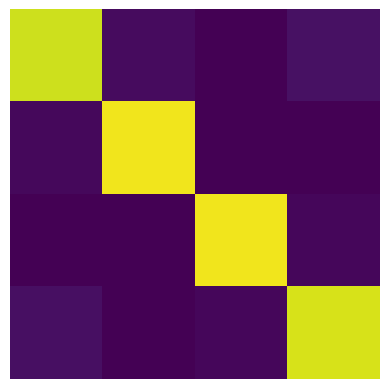

Error rate of 0.04483991008989563


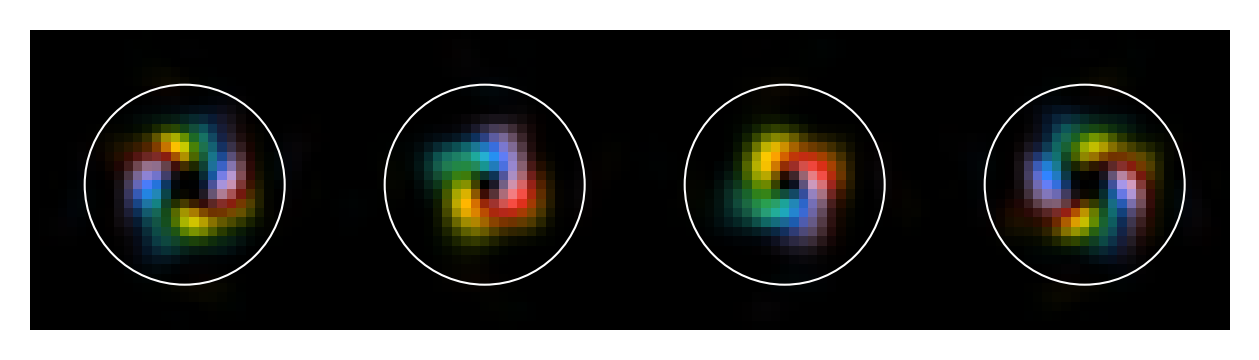

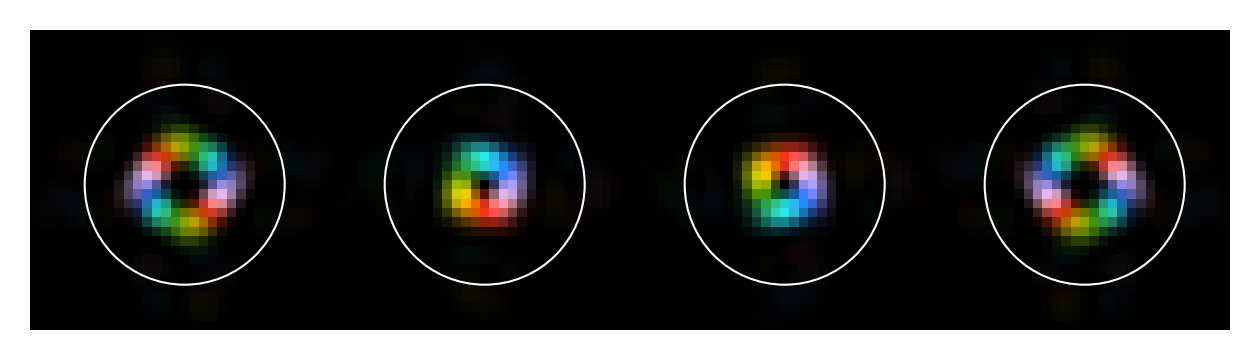

In [16]:
beams=[propChannel(OAM(F,w0,i),z,numberOfPhaseScreens,0) for i in progress(ell(4))]
errorBeams=[propChannel(OAM(F,w0,i),z,abbs) for i in progress(ell(4))]


plt.show(plotCrosstalk(crosstalk(beams,errorBeams)))
print(f'Error rate of {beamsError(beams,errorBeams)}')

plt.show(plotBeam(errorBeams,rows=1,aperature=size/3))
plt.show(plotBeam(beams,rows=1,aperature=size/3))

## Propagate a Singel Pixel with No Turbulence

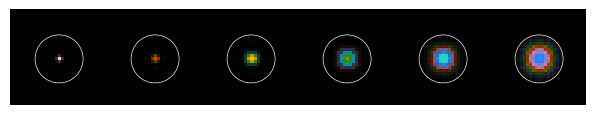

In [17]:
intens = np.zeros((N, N))
intens[N//2][N//2] = 1

#FieldOut = propChannel(SubIntensity(FieldIn, intens), z, abbs)
#FieldOut = propChannel(CircAperture(SubIntensity(FieldIn, intens),FieldIn.siz/2), z, abbs)
F2 = [CircAperture(propChannel(CircAperture(SubPhase(SubIntensity(F, intens),np.zeros((N,N))),R=lensSize), dist),R=lensSize) for dist in [1,1000,2000,3000,4000,5000]]

plt.show(plotBeam(F2,aperature=lensSize,dpi=3*N))


## Propagate all Pixels

In [ ]:
for j in range(N):
    for i in range(N):
        propagateSinglePixel(F, j, i, N, z, lensSize, abbs)


Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker started
Worker sta

: 

: 

In [20]:
import os
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm as progress
from worker_utils import init_worker, propagateSinglePixel_Optimized

def parallelpropagatePixels(FieldIn, N, z, lensSize, abbs):
    FieldsOut = []
    endFields_data = []
    
    # Determine worker count (Platform Agnostic)
    max_workers = max(1, (os.cpu_count() or 4) - 2)
    print(f"Using {max_workers} workers to propagate beams...")

    # Create task list of coordinate indices
    tasks = [(j, i) for j in range(N) for i in range(N)]

    # Use raw data for better serialization performance on Windows
    field_raw = FieldIn.field
    size = FieldIn.siz
    wavelength = FieldIn.lam
    
    # ProcessPoolExecutor with initializer for shared data efficiency
    with ProcessPoolExecutor(
        max_workers=max_workers,
        initializer=init_worker,
        initargs=(field_raw, size, wavelength, N, z, lensSize, abbs)
    ) as executor:
        
        future_to_task = {
            executor.submit(propagateSinglePixel_Optimized, j, i): (j, i) 
            for j, i in tasks
        }
        
        results_iterator = progress(
            as_completed(future_to_task), 
            total=len(tasks), 
            desc="Propagating individual Pixels"
        )
        
        for future in results_iterator:
            try:
                FieldOut, endField_data = future.result()
                FieldsOut.append(FieldOut)
                endFields_data.append(endField_data)
            except Exception as exc:
                j, i = future_to_task[future]
                print(f'\n(j={j}, i={i}) generated an exception: {exc}')
                
    return FieldsOut, np.array(endFields_data)

# Execution block
if __name__ == "__main__":
    # Parameters should be defined in previous notebook cells
    # F, N, z, lensSize, abbs must be ready
    FieldsOut, endFields = parallelpropagatePixels(F, N, z, lensSize, abbs)
    print(f"Successfully processed {len(endFields)} pixels.")

Using 6 workers to propagate beams...


Propagating individual Pixels: 100%|██████████| 1024/1024 [00:03<00:00, 312.97it/s]


Successfully processed 1024 pixels.


# Calculate EigenModes

In [60]:
transferMatrix=endFields

transferMatrixT=endFields.T

transferMatrixH=endFields.T.conj()

transferMatrixHermitian=transferMatrixH@transferMatrix

eigVals,eigVecs=np.linalg.eig(transferMatrixT)

#Get the absolute values and phases of the eigenvalues
eigMags=abs(eigVals)

In [61]:
# Sort the Eigenvalues by the magnitudes
sort_indices = np.argsort(eigMags)[::-1]
eigMags = eigMags[sort_indices]
eigVals = eigVals[sort_indices]
eigVecs = eigVecs[:, sort_indices]

## Plot Eigenvalues

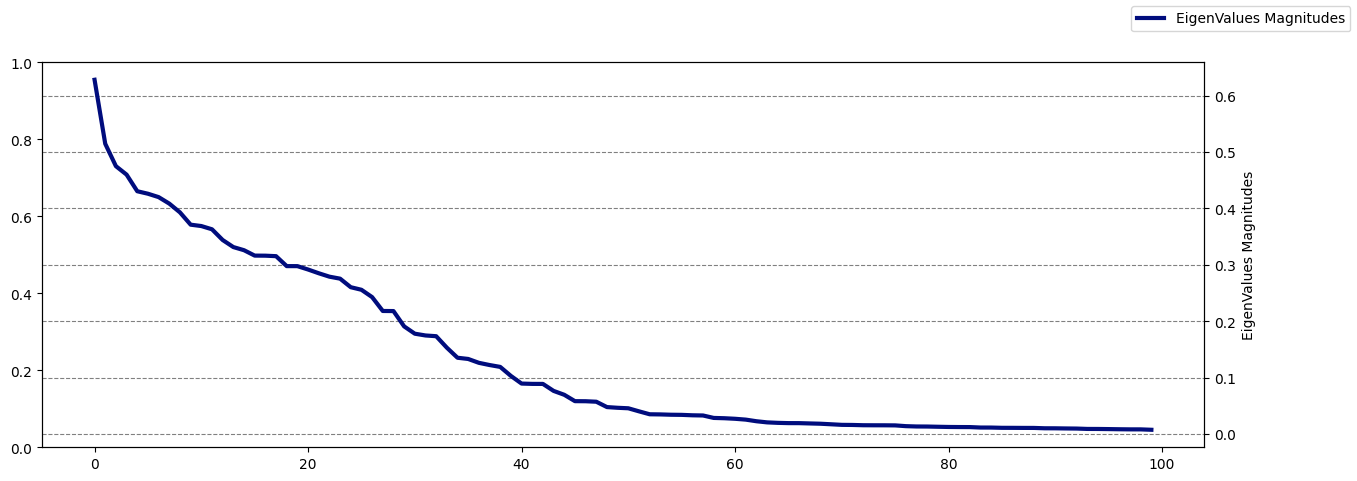

In [62]:
# Plot the eigenvalues

fig, ax1 = plt.subplots()
fig.set_size_inches(15,5)
x=range(0,len(eigMags))
ax2 = ax1.twinx()
ax2.yaxis.grid(True)
ax2.grid(visible=True,which='major',axis='both',color='gray',linestyle='--')
#ax1.set_ylabel('EigenValues Phases')
ax2.set_ylabel('EigenValues Magnitudes')

ax2.plot(x[:100],eigMags[:100],label='EigenValues Magnitudes',color=customColoursBGY[0],linewidth=3)

fig.legend()
plt.show()

## Create Optical Modes

In [63]:
#Making Eigenvector optical modes
F=Begin(size,wavelength,N)
eigenBeams=[]
for i in progress(range(100)):
    mode=eigVecs[:,i]
    eigenInt=[abs(val)**2 for val in mode]
    eigenInt=np.pad(np.array(eigenInt).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    eigenPhase=[cmath.phase(val) for val in mode]
    eigenPhase=np.pad(np.array(eigenPhase).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    F=SubPhase(SubIntensity(F,eigenInt),eigenPhase)
    eigenBeams.append(F)

eigenBeamPropagated=[propChannel(beam,z,abbs) for beam in progress(eigenBeams)]


100%|██████████| 100/100 [00:00<00:00, 710.36it/s]


### Normalize phase for plotting

In [64]:
############################
####
####
#### Need to normalize the phase on the propagated eigenmode to be able 
####    to display them next to one another and have consistent phase profiles.
####
############################

## Plot Optical Modes

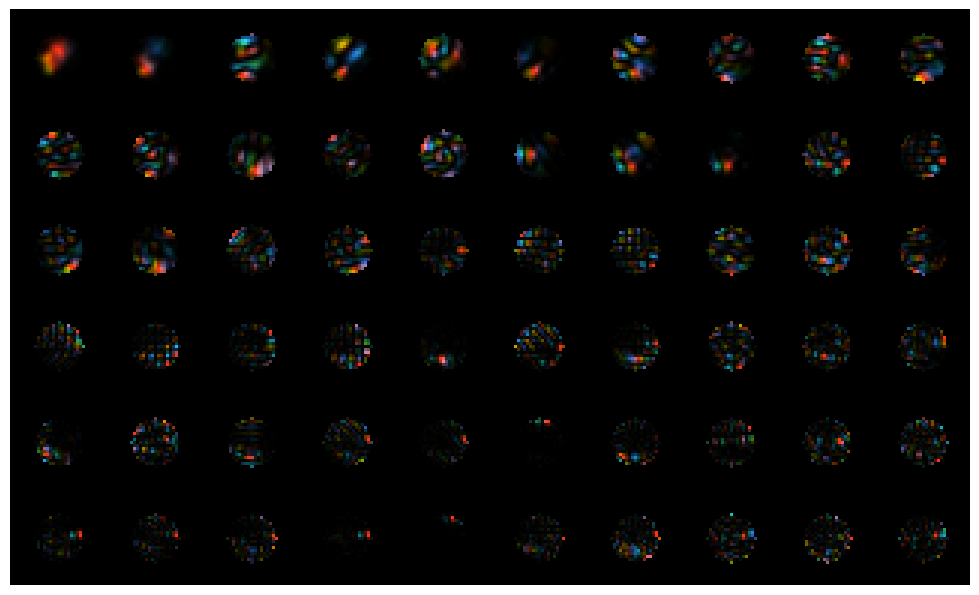

In [65]:
plot=plotBeam(eigenBeams[:60],rows=6,dpi=N*3)
plt.show();plt.close()

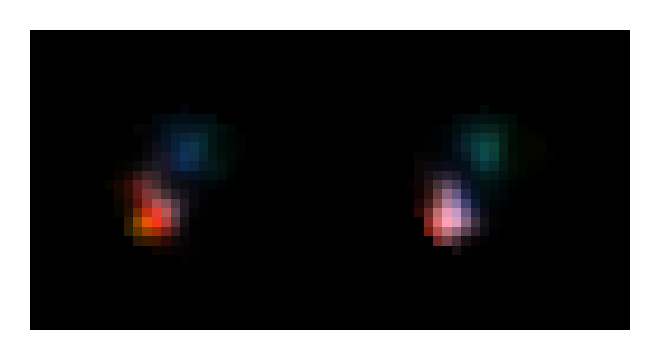

In [66]:
plt.show(plotBeam([eigenBeams[1],CircAperture(propChannel(eigenBeams[1],z,abbs),R=lensSize)]))

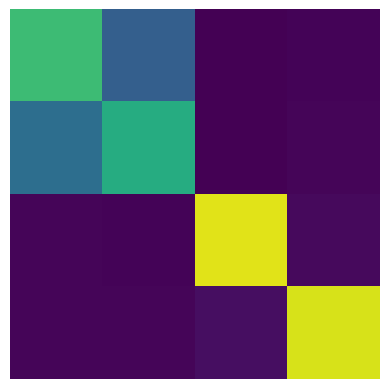

Error rate of 0.20084355836982082 when doing a measurement in the unpropagated Eigenmode basis


In [67]:
modeNumber=4

bestEigenBeams=eigenBeams[:modeNumber]
bestEigenBeamsPropagated=eigenBeamPropagated[:modeNumber]


plt.show(plotCrosstalk(crosstalk(bestEigenBeams,bestEigenBeamsPropagated)))
print(f'Error rate of {beamsError(bestEigenBeams,bestEigenBeamsPropagated)} when doing a measurement in the unpropagated Eigenmode basis')